# Summary 

## Kai Yang
## <kai.yang2 "at" mail.mcgill.ca>
## [GPG Public key Fingerprint: B080 1753 189F BAFE 10B5  3E8A 0F6C F129 F618 CEEF](https://keys.openpgp.org/vks/v1/by-fingerprint/B0801753189FBAFE10B53E8A0F6CF129F618CEEF)

In [1]:
import os, sys
import collections
import numpy as np
from scipy.special import logsumexp
import matplotlib.markers as markers
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
import timeit
from scipy.stats import median_abs_deviation as mad
import pandas as pd
import multiprocessing
import cProfile
import itertools
import warnings

warnings.filterwarnings('ignore')  # this is just to hide all the warnings

import matplotlib.pyplot as plt  # change font globally to Times

plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.sans-serif": ["Times New Roman"],
    "font.size": 12
})

os.chdir(sys.path[0])  # ensure working direcotry is set same as the file

In [2]:
def pasta(a, b):
    '''
    A function that pastes the results all together.
    '''
    c = a.astype(str).copy()
    c = np.char.add(c, np.array([" ("] * a.size).reshape(a.shape))
    c = np.char.add(c, b.astype(str))
    c = np.char.add(c, np.array([")"] * a.size).reshape(a.shape))
    return c

# LM -- Speed
## Iterations required to make same amount of descent
### SCAD

In [3]:
SCAD_sim_results = np.load("./tasks/task1speed/SCAD_sim_results.npy")

SCAD_sim_results_mean = np.around(np.median(SCAD_sim_results, 2), 3)
print("Median:")
print("AG: ", SCAD_sim_results_mean[..., 0])
print("proximal gradient: ", SCAD_sim_results_mean[..., 1])
print("original settings: ", SCAD_sim_results_mean[..., 2])
SCAD_sim_results_se = np.around(mad(SCAD_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", SCAD_sim_results_se[..., 0])
print("proximal gradinet: ", SCAD_sim_results_se[..., 1])
print("original settings: ", SCAD_sim_results_se[..., 2])

LM_SCAD_iterations_latex = pasta(SCAD_sim_results_mean, SCAD_sim_results_se)

Median:
AG:  [[  9.  14.  23.  26.]
 [ 11.  18.  32.  50.]
 [ 37.  72. 172. 432.]]
proximal gradient:  [[  11.    26.    68.    93.5]
 [  21.    38.   116.   308. ]
 [ 104.   362.  2012.5    inf]]
original settings:  [[ 15.  23.  38.  41.]
 [ 19.  30.  51.  76.]
 [ 60. 111. 260. 657.]]
Scaled MAD: 
AG:  [[ 1.483  0.     1.483  1.483]
 [ 1.483  0.     1.483  1.483]
 [ 1.483  2.965  8.154 25.204]]
proximal gradinet:  [[ 4.448  1.483  5.93   6.672]
 [ 7.413  2.224  6.672 19.274]
 [ 7.413 19.274 88.215    nan]]
original settings:  [[ 1.483  1.483  1.483  1.483]
 [ 1.483  1.483  1.483  2.965]
 [ 2.965  4.448 11.861 37.065]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


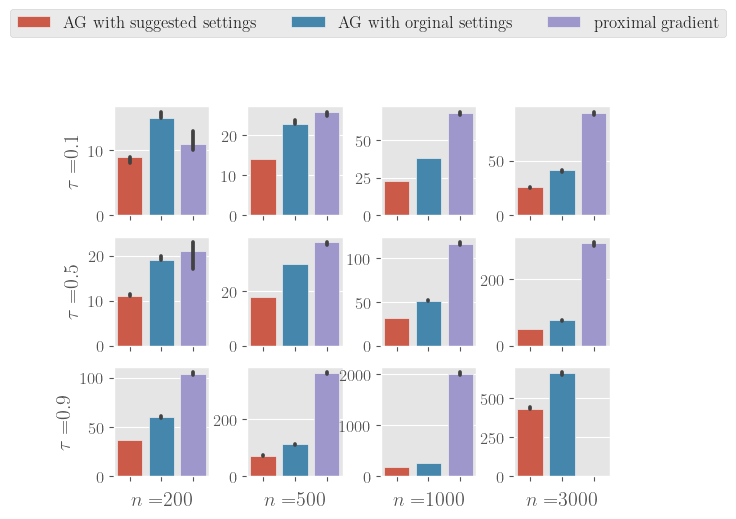

In [4]:
fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient',
        'AG with orginal settings'
    ],
                      data=SCAD_sim_results[i, j, :, :3])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings',
                            'AG with orginal settings', 'proximal gradient'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('LM-fig_k_SCAD.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

### MCP

In [5]:
MCP_sim_results = np.load("./tasks/task1speed/MCP_sim_results.npy")

MCP_sim_results_mean = np.around(np.median(MCP_sim_results, 2), 3)
print("Median:")
print("AG: ", MCP_sim_results_mean[..., 0])
print("proximal gradient: ", MCP_sim_results_mean[..., 1])
print("original settings: ", MCP_sim_results_mean[..., 2])
MCP_sim_results_se = np.around(mad(MCP_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", MCP_sim_results_se[..., 0])
print("proximal gradient: ", MCP_sim_results_se[..., 1])
print("original settings: ", MCP_sim_results_se[..., 2])

LM_MCP_iterations_latex = pasta(MCP_sim_results_mean, MCP_sim_results_se)

Median:
AG:  [[  6.   10.   17.   25. ]
 [ 10.   15.   26.   48. ]
 [ 31.   68.  152.  428.5]]
proximal gradient:  [[   7.    16.    48.    90. ]
 [  12.    28.    94.   289.5]
 [  82.   345.  1897.5    inf]]
original settings:  [[  9.   18.   29.   40. ]
 [ 17.   26.   42.   74.5]
 [ 50.  104.  226.5 657. ]]
Scaled MAD: 
AG:  [[ 1.483  0.     0.     1.483]
 [ 1.483  0.741  1.483  1.483]
 [ 1.483  2.965  7.413 24.463]]
proximal gradient:  [[ 1.483  0.     2.965  5.93 ]
 [ 2.965  1.483  5.93  17.05 ]
 [ 5.93  19.274 85.991    nan]]
original settings:  [[ 0.     1.483  1.483  1.483]
 [ 1.483  1.483  1.483  2.224]
 [ 1.483  3.706 10.378 37.065]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


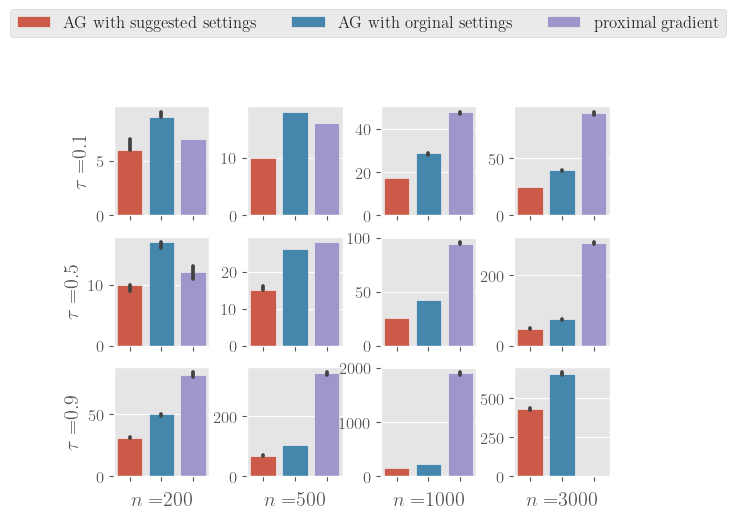

In [6]:
fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient',
        'AG with orginal settings'
    ],
                      data=MCP_sim_results[i, j, :, :3])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings',
                            'AG with orginal settings', 'proximal gradient'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('LM-fig_k_MCP.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

## Computing time
### SCAD

Median:
AG:  [[ 0.373  0.534  1.362  1.922]
 [ 0.448  0.606  1.54   1.809]
 [ 0.952  2.563  7.63  12.048]]
proximal gradient:  [[ 0.956  1.175  1.855 10.198]
 [ 1.269  1.392  2.318  6.392]
 [ 2.874  3.431  9.864 10.146]]
coordinate descent:  [[  15.55    17.444   28.8    113.09 ]
 [  16.402   17.604   42.126  192.064]
 [  18.725   50.399  217.842 1071.519]]
Scaled MAD: 
AG:  [[0.088 0.117 0.222 0.572]
 [0.078 0.11  0.142 0.225]
 [0.131 0.11  0.317 0.076]]
proximal gradient:  [[0.253 0.42  0.53  0.274]
 [0.265 0.451 0.462 1.942]
 [0.728 0.693 0.053 0.05 ]]
coordinate descent:  [[ 1.569  2.73   2.115  4.57 ]
 [ 2.618  2.794  1.485  7.518]
 [ 4.359  1.299  9.    46.651]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


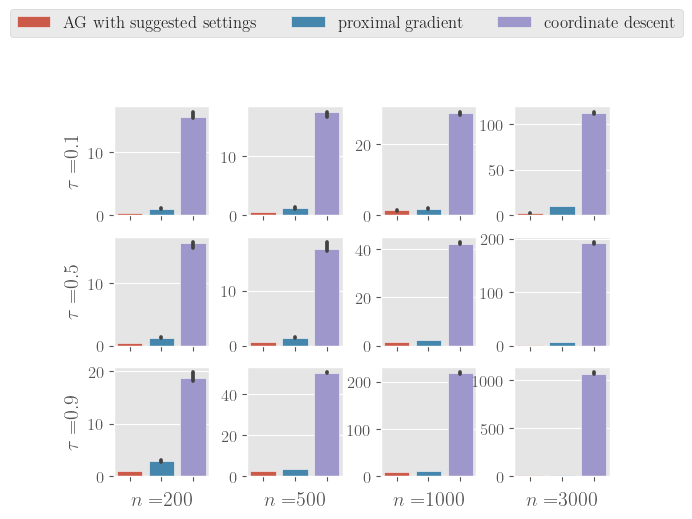

In [7]:
SCAD_sim_results = np.load("./tasks/task1speed/SCAD_sim_results.npy")

SCAD_sim_results_mean = np.around(np.median(SCAD_sim_results, 2), 3)
print("Median:")
print("AG: ", SCAD_sim_results_mean[..., 3])
print("proximal gradient: ", SCAD_sim_results_mean[..., 4])
print("coordinate descent: ", SCAD_sim_results_mean[..., 5])
SCAD_sim_results_se = np.around(mad(SCAD_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", SCAD_sim_results_se[..., 3])
print("proximal gradient: ", SCAD_sim_results_se[..., 4])
print("coordinate descent: ", SCAD_sim_results_se[..., 5])

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient', 'coordinate descent'
    ],
                      data=SCAD_sim_results[i, j, :, 3:])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings', 'proximal gradient',
                            'coordinate descent'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('LM-time_SCAD.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

LM_SCAD_computing_time_latex = pasta(SCAD_sim_results_mean,
                                     SCAD_sim_results_se)

### MCP

Median:
AG:  [[ 0.288  0.403  0.873  1.506]
 [ 0.343  0.475  1.084  1.613]
 [ 0.767  2.085  6.23  10.256]]
proximal gradient:  [[0.723 0.884 1.286 7.583]
 [0.994 1.074 1.547 5.523]
 [2.331 2.656 8.191 8.41 ]]
coordinate descent:  [[ 13.549  15.074  24.001  94.465]
 [ 14.45   15.289  35.291 159.981]
 [ 16.17   41.568 181.614 882.174]]
Scaled MAD: 
AG:  [[0.048 0.099 0.118 0.514]
 [0.076 0.095 0.056 0.182]
 [0.098 0.09  0.25  0.032]]
prximal gradient:  [[0.194 0.271 0.344 1.401]
 [0.23  0.271 0.391 1.529]
 [0.518 0.465 0.033 0.03 ]]
coordinate descent:  [[ 2.414  2.496  2.215  3.67 ]
 [ 2.985  3.673  1.39   6.67 ]
 [ 2.429  1.608  7.891 37.62 ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


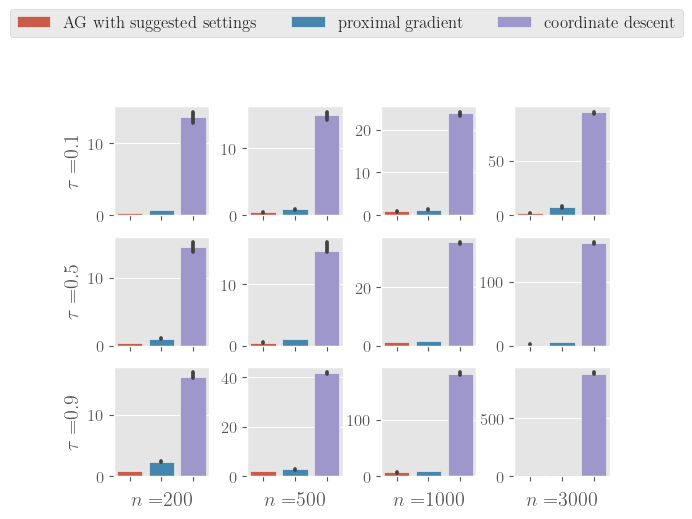

In [8]:
MCP_sim_results = np.load("./tasks/task1speed/MCP_sim_results.npy")

MCP_sim_results_mean = np.around(np.median(MCP_sim_results, 2), 3)
print("Median:")
print("AG: ", MCP_sim_results_mean[..., 3])
print("proximal gradient: ", MCP_sim_results_mean[..., 4])
print("coordinate descent: ", MCP_sim_results_mean[..., 5])
MCP_sim_results_se = np.around(mad(MCP_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", MCP_sim_results_se[..., 3])
print("prximal gradient: ", MCP_sim_results_se[..., 4])
print("coordinate descent: ", MCP_sim_results_se[..., 5])

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient', 'coordinate descent'
    ],
                      data=MCP_sim_results[i, j, :, 3:])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings', 'proximal gradient',
                            'coordinate descent'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('LM-time_MCP.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

LM_MCP_computing_time_latex = pasta(MCP_sim_results_mean, MCP_sim_results_se)

# LM -- Signals
## SCAD
### AG

In [9]:
results_SCAD_signal_recovery = np.load(
    "./tasks/task1/results_SCAD_signal_recovery.npy")

results_SCAD_signal_recovery_mean = np.around(
    np.mean(results_SCAD_signal_recovery, 2), 3)
results_SCAD_signal_recovery_se = np.around(
    np.std(results_SCAD_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 0],
          results_SCAD_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 1],
          results_SCAD_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 2],
          results_SCAD_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 3],
          results_SCAD_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_SCAD_signal_recovery_se[..., 4]))

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_median[...,2])
# print("specificity: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_mad[...,2])
# print("specificity: ",results_SCAD_signal_recovery_mad[...,3])

LM_SCAD_signal_latex = pasta(results_SCAD_signal_recovery_mean,
                             results_SCAD_signal_recovery_se)

Sample mean:
2-norm:  [['0.128 (0.021)' '0.521 (0.114)' '2.839 (0.497)']
 ['0.05 (0.009)' '0.156 (0.035)' '2.075 (0.339)']
 ['0.022 (0.004)' '0.085 (0.014)' '1.278 (0.262)']
 ['0.016 (0.003)' '0.065 (0.011)' '1.163 (0.207)']]
infinity-norm:  [['21.305 (2.587)' '48.871 (5.73)' '162.521 (37.275)']
 ['13.026 (2.287)' '25.035 (4.464)' '114.369 (21.125)']
 ['8.768 (1.787)' '18.119 (2.626)' '75.329 (14.609)']
 ['7.393 (1.711)' '16.366 (2.458)' '69.954 (11.687)']]
PPV:  [['0.747 (0.134)' '0.622 (0.188)' '0.488 (0.25)']
 ['0.681 (0.162)' '0.551 (0.206)' '0.327 (0.234)']
 ['0.58 (0.138)' '0.42 (0.257)' '0.197 (0.141)']
 ['0.528 (0.272)' '0.437 (0.09)' '0.211 (0.081)']]
NPV:  [['0.984 (0.001)' '0.984 (0.001)' '0.979 (0.001)']
 ['0.989 (0.001)' '0.988 (0.002)' '0.98 (0.001)']
 ['0.992 (0.001)' '0.991 (0.001)' '0.981 (0.001)']
 ['0.993 (0.001)' '0.992 (0.001)' '0.982 (0.001)']]
active set cardi:  [['25.82 (8.08)' '31.58 (17.056)' '23.11 (15.166)']
 ['42.78 (14.003)' '55.48 (20.653)' '42.83 (16.308

### ncvreg

In [10]:
results_SCAD_signal_recovery = np.load(
    "./SCAD_MCP/LM/R_results_SCAD_signal_recovery.npy")

results_SCAD_signal_recovery = np.reshape(results_SCAD_signal_recovery,
                                          (4, 3, 100, 5),
                                          "F")  # keep array dimension true
results_SCAD_signal_recovery_mean = np.around(
    np.mean(results_SCAD_signal_recovery, 2), 3)
results_SCAD_signal_recovery_se = np.around(
    np.std(results_SCAD_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 0],
          results_SCAD_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 1],
          results_SCAD_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 2],
          results_SCAD_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 3],
          results_SCAD_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_SCAD_signal_recovery_se[..., 4]))

ncvreg_LM_SCAD_signal_latex = pasta(results_SCAD_signal_recovery_mean,
                                    results_SCAD_signal_recovery_se)

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_median[...,2])
# print("specificity: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_mad[...,2])
# print("specificity: ",results_SCAD_signal_recovery_mad[...,3])

Sample mean:
2-norm:  [['0.131 (0.02)' '0.485 (0.102)' '2.929 (0.525)']
 ['0.052 (0.009)' '0.156 (0.028)' '2.087 (0.357)']
 ['0.021 (0.004)' '0.083 (0.015)' '1.3 (0.262)']
 ['0.015 (0.003)' '0.063 (0.013)' '1.167 (0.22)']]
infinity-norm:  [['20.455 (2.921)' '46.659 (5.714)' '170.52 (37.138)']
 ['13.052 (2.262)' '25.202 (4.255)' '117.133 (22.303)']
 ['8.363 (1.563)' '17.958 (2.548)' '80.005 (15.153)']
 ['7.079 (1.189)' '16.033 (2.414)' '73.369 (12.624)']]
PPV:  [['0.255 (0.061)' '0.287 (0.132)' '0.286 (0.19)']
 ['0.282 (0.079)' '0.307 (0.098)' '0.275 (0.148)']
 ['0.32 (0.065)' '0.344 (0.152)' '0.175 (0.101)']
 ['0.349 (0.127)' '0.409 (0.1)' '0.206 (0.047)']]
NPV:  [['0.987 (0.001)' '0.986 (0.001)' '0.98 (0.001)']
 ['0.99 (0.001)' '0.989 (0.001)' '0.98 (0.001)']
 ['0.993 (0.001)' '0.991 (0.001)' '0.981 (0.001)']
 ['0.993 (0.001)' '0.992 (0.001)' '0.982 (0.001)']]
active set cardi:  [['100.88 (25.582)' '94.32 (41.572)' '42.01 (20.592)']
 ['120.17 (33.554)' '101.75 (29.498)' '46.72 (16.252

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


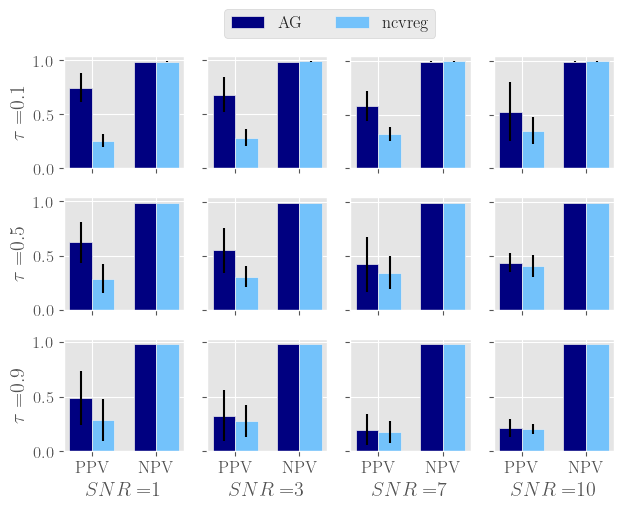

In [11]:
AG = np.load("./tasks/task1/results_SCAD_signal_recovery.npy")
AG_mean = np.mean(AG, 2)
AG_se = np.std(AG, 2)
ncvreg = np.load("./SCAD_MCP/LM/R_results_SCAD_signal_recovery.npy")
ncvreg = np.reshape(ncvreg, (4, 3, 100, 5), "F")  # keep array dimension true
ncvreg_mean = np.mean(ncvreg, 2)
ncvreg_se = np.std(ncvreg, 2)

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
SNR = np.array([1, 3, 7, 10])

for i, j in itertools.product(range(3), range(4)):
    data = np.array([[AG_mean[j, i, 2], ncvreg_mean[j, i, 2]],
                     [AG_mean[j, i, 3], ncvreg_mean[j, i, 3]]])
    data_se = np.array([[AG_se[j, i, 2], ncvreg_se[j, i, 2]],
                        [AG_se[j, i, 3], ncvreg_se[j, i, 3]]])
    length = len(data)
    x_labels = ["PPV", "NPV"]
    width = 0.35  # width of bar
    x = np.arange(length)
    axes[i, j].bar(x,
                   data[:, 0],
                   width,
                   color='#000080',
                   label='AG',
                   yerr=data_se[:, 0])
    axes[i, j].bar(x + width,
                   data[:, 1],
                   width,
                   color='#73C2FB',
                   label='ncvreg',
                   yerr=data_se[:, 1])
    #     ax.set_ylabel('Proportion')
    #     ax.set_ylim(0,75)
    axes[i, j].set_xticks(x + width / 2)
    axes[i, j].set_xticklabels(x_labels)
    axes[i, j].set_xlabel('Predicted Values')
    #     ax.set_title('Title')
    #     axes[i,j].legend()

    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=r"$SNR=$" + str(SNR[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=x_labels,
                   xlabel=r"$SNR=$" + str(SNR[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels, xlabel=None, ylabel=None)

for ax in axes.flat:
    ax.label_outer()

# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout(pad=.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=4,
           bbox_to_anchor=(.35, 1.075))

plt.tight_layout()
plt.savefig('LM-SCAD-pv.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

## MCP
### AG

In [12]:
results_MCP_signal_recovery = np.load(
    "./tasks/task1/results_MCP_signal_recovery.npy")

results_MCP_signal_recovery_mean = np.around(
    np.mean(results_MCP_signal_recovery, 2), 3)
results_MCP_signal_recovery_se = np.around(
    np.std(results_MCP_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 0],
          results_MCP_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 1],
          results_MCP_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 2],
          results_MCP_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 3],
          results_MCP_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_MCP_signal_recovery_mean[..., 4],
          results_MCP_signal_recovery_se[..., 4]))

LM_MCP_signal_latex = pasta(results_MCP_signal_recovery_mean,
                            results_MCP_signal_recovery_se)

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_median[...,2])
# print("specificity: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_mad[...,2])
# print("specificity: ",results_MCP_signal_recovery_mad[...,3])

Sample mean:
2-norm:  [['0.133 (0.022)' '0.563 (0.124)' '2.839 (0.39)']
 ['0.049 (0.01)' '0.169 (0.034)' '1.997 (0.329)']
 ['0.021 (0.004)' '0.088 (0.016)' '1.503 (0.329)']
 ['0.014 (0.003)' '0.059 (0.011)' '1.084 (0.272)']]
infinity-norm:  [['22.014 (2.296)' '50.653 (5.53)' '155.29 (27.652)']
 ['13.592 (2.481)' '24.899 (4.824)' '109.26 (20.11)']
 ['9.05 (1.833)' '18.262 (3.055)' '86.307 (18.311)']
 ['7.536 (1.767)' '15.241 (2.924)' '67.75 (13.749)']]
PPV:  [['0.85 (0.081)' '0.744 (0.161)' '0.616 (0.208)']
 ['0.842 (0.119)' '0.732 (0.21)' '0.506 (0.286)']
 ['0.761 (0.175)' '0.646 (0.293)' '0.505 (0.218)']
 ['0.801 (0.099)' '0.489 (0.134)' '0.375 (0.225)']]
NPV:  [['0.983 (0.001)' '0.982 (0.001)' '0.979 (0.001)']
 ['0.988 (0.001)' '0.986 (0.001)' '0.98 (0.001)']
 ['0.991 (0.001)' '0.989 (0.001)' '0.981 (0.001)']
 ['0.992 (0.001)' '0.99 (0.001)' '0.982 (0.001)']]
active set cardi:  [['19.7 (4.584)' '20.6 (9.45)' '12.5 (8.163)']
 ['30.55 (8.437)' '34.52 (16.44)' '25.37 (14.373)']
 ['44.45

### ncvreg

In [13]:
results_MCP_signal_recovery = np.load(
    "./SCAD_MCP/LM/R_results_MCP_signal_recovery.npy")

results_MCP_signal_recovery = np.reshape(results_MCP_signal_recovery,
                                         (4, 3, 100, 5),
                                         "F")  # keep array dimension true
results_MCP_signal_recovery_mean = np.around(
    np.mean(results_MCP_signal_recovery, 2), 3)
results_MCP_signal_recovery_se = np.around(
    np.std(results_MCP_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 0],
          results_MCP_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 1],
          results_MCP_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 2],
          results_MCP_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 3],
          results_MCP_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_MCP_signal_recovery_mean[..., 4],
          results_MCP_signal_recovery_se[..., 4]))

ncvreg_LM_MCP_signal_latex = pasta(results_MCP_signal_recovery_mean,
                                   results_MCP_signal_recovery_se)

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_median[...,2])
# print("specificity: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_mad[...,2])
# print("specificity: ",results_MCP_signal_recovery_mad[...,3])

Sample mean:
2-norm:  [['0.126 (0.019)' '0.494 (0.112)' '2.86 (0.427)']
 ['0.048 (0.009)' '0.161 (0.032)' '1.92 (0.34)']
 ['0.02 (0.004)' '0.086 (0.017)' '1.416 (0.302)']
 ['0.014 (0.003)' '0.059 (0.013)' '1.134 (0.248)']]
infinity-norm:  [['20.675 (2.83)' '48.338 (5.946)' '161.317 (31.908)']
 ['13.192 (2.269)' '25.203 (4.041)' '106.248 (19.925)']
 ['8.395 (1.559)' '18.375 (2.558)' '81.467 (15.7)']
 ['7.064 (1.283)' '15.031 (2.751)' '69.502 (12.619)']]
PPV:  [['0.435 (0.085)' '0.407 (0.135)' '0.387 (0.154)']
 ['0.505 (0.112)' '0.514 (0.121)' '0.366 (0.18)']
 ['0.541 (0.128)' '0.547 (0.173)' '0.483 (0.201)']
 ['0.559 (0.107)' '0.476 (0.135)' '0.377 (0.225)']]
NPV:  [['0.986 (0.001)' '0.984 (0.001)' '0.979 (0.0)']
 ['0.989 (0.001)' '0.987 (0.001)' '0.98 (0.001)']
 ['0.992 (0.001)' '0.989 (0.001)' '0.981 (0.001)']
 ['0.993 (0.001)' '0.99 (0.001)' '0.982 (0.001)']]
active set cardi:  [['51.61 (13.612)' '47.32 (16.093)' '20.25 (11.411)']
 ['60.14 (15.873)' '48.08 (13.783)' '31.0 (13.981)']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


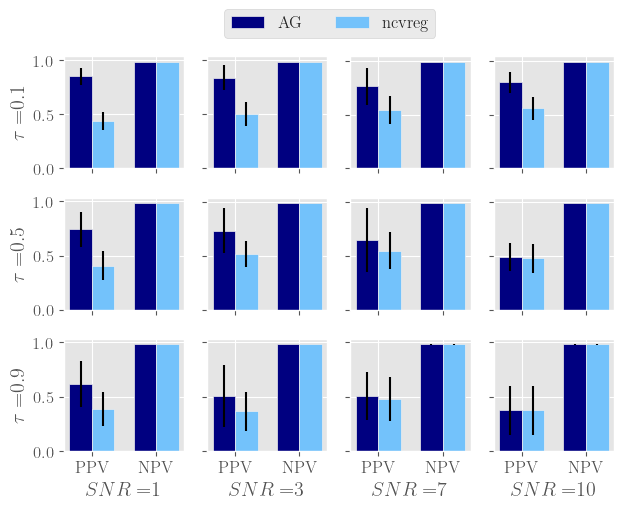

In [14]:
AG = np.load("./tasks/task1/results_MCP_signal_recovery.npy")
AG_mean = np.mean(AG, 2)
AG_se = np.std(AG, 2)
ncvreg = np.load("./SCAD_MCP/LM/R_results_MCP_signal_recovery.npy")
ncvreg = np.reshape(ncvreg, (4, 3, 100, 5), "F")  # keep array dimension true
ncvreg_mean = np.mean(ncvreg, 2)
ncvreg_se = np.std(ncvreg, 2)

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
SNR = np.array([1, 3, 7, 10])

for i, j in itertools.product(range(3), range(4)):
    data = np.array([[AG_mean[j, i, 2], ncvreg_mean[j, i, 2]],
                     [AG_mean[j, i, 3], ncvreg_mean[j, i, 3]]])
    data_se = np.array([[AG_se[j, i, 2], ncvreg_se[j, i, 2]],
                        [AG_se[j, i, 3], ncvreg_se[j, i, 3]]])
    length = len(data)
    x_labels = ["PPV", "NPV"]
    width = 0.35  # width of bar
    x = np.arange(length)
    axes[i, j].bar(x,
                   data[:, 0],
                   width,
                   color='#000080',
                   label='AG',
                   yerr=data_se[:, 0])
    axes[i, j].bar(x + width,
                   data[:, 1],
                   width,
                   color='#73C2FB',
                   label='ncvreg',
                   yerr=data_se[:, 1])
    #     ax.set_ylabel('Proportion')
    #     ax.set_ylim(0,75)
    axes[i, j].set_xticks(x + width / 2)
    axes[i, j].set_xticklabels(x_labels)
    axes[i, j].set_xlabel('Predicted Values')
    #     ax.set_title('Title')
    #     axes[i,j].legend()

    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=r"$SNR=$" + str(SNR[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=x_labels,
                   xlabel=r"$SNR=$" + str(SNR[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels, xlabel=None, ylabel=None)

for ax in axes.flat:
    ax.label_outer()

# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout(pad=.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=4,
           bbox_to_anchor=(.35, 1.075))

plt.tight_layout()
plt.savefig('LM-MCP-pv.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# logistic -- Speed
## Iterations required to make same amount of descent
### SCAD

In [15]:
SCAD_sim_results = np.load("./tasks/task2speed/sub_tasks/task2speed_SCAD/SCAD_sim_results.npy")

SCAD_sim_results_mean = np.around(np.median(SCAD_sim_results, 2), 3)
print("Median:")
print("AG: ", SCAD_sim_results_mean[..., 0])
print("proximal gradient: ", SCAD_sim_results_mean[..., 1])
print("original settings: ", SCAD_sim_results_mean[..., 2])
SCAD_sim_results_se = np.around(mad(SCAD_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", SCAD_sim_results_se[..., 0])
print("proximal gradient: ", SCAD_sim_results_se[..., 1])
print("original settings: ", SCAD_sim_results_se[..., 2])

logistic_SCAD_iterations_latex = pasta(SCAD_sim_results_mean,
                                       SCAD_sim_results_se)

Median:
AG:  [[ 33.   18.   10.    7. ]
 [ 37.   19.   10.    7. ]
 [144.   46.5  27.5  16.5]]
proximal gradient:  [[ 193.5   74.5   24.    11. ]
 [ 249.5   76.    23.    13. ]
 [3209.   256.5   95.    45. ]]
original settings:  [[ 48.5  29.5  17.5  12. ]
 [ 55.   31.   17.   13. ]
 [207.   70.5  41.   26.5]]
Scaled MAD: 
AG:  [[ 4.448  3.706  1.483  1.483]
 [ 4.448  2.965  1.483  1.483]
 [68.2   14.826  9.637  5.189]]
proximal gradient:  [[4.966700e+01 2.891100e+01 4.448000e+00 1.483000e+00]
 [6.449300e+01 3.187600e+01 5.930000e+00 1.483000e+00]
 [2.786547e+03 1.623450e+02 5.115000e+01 1.927400e+01]]
original settings:  [[  5.93    5.189   1.483   1.483]
 [  5.93    5.93    1.483   1.483]
 [100.817  24.463  14.826   6.672]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


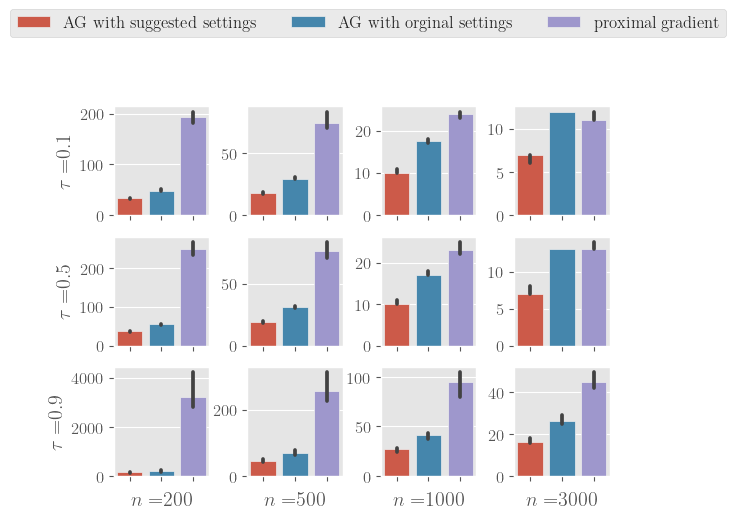

In [16]:
fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient',
        'AG with orginal settings'
    ],
                      data=SCAD_sim_results[i, j, ...])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings',
                            'AG with orginal settings', 'proximal gradient'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('logistic-fig_k_SCAD.eps',
            format='eps',
            dpi=600,
            bbox_inches='tight')
plt.show()

### MCP

In [17]:
MCP_sim_results = np.load("./tasks/task2speed/sub_tasks/task2speed_MCP/MCP_sim_results.npy")

MCP_sim_results_mean = np.median(MCP_sim_results, 2)
print("Median:")
print("AG: ", MCP_sim_results_mean[..., 0])
print("proximal gradient: ", MCP_sim_results_mean[..., 1])
print("original settings: ", MCP_sim_results_mean[..., 2])
MCP_sim_results_se = np.around(mad(MCP_sim_results, 2) * 1.4826, 3)
print("Scaled MAD: ")
print("AG: ", MCP_sim_results_se[..., 0])
print("proximal gradient: ", MCP_sim_results_se[..., 1])
print("original settings: ", MCP_sim_results_se[..., 2])

logistic_MCP_iterations_latex = pasta(MCP_sim_results_mean, MCP_sim_results_se)

Median:
AG:  [[22.  29.5 10.   7. ]
 [24.  25.  11.   7. ]
 [62.  48.5 27.  18. ]]
proximal gradient:  [[ 80.  187.   22.   11. ]
 [ 96.  123.5  25.5  13. ]
 [598.  264.  106.   49. ]]
original settings:  [[33.  45.  17.  12. ]
 [37.  39.  18.  13. ]
 [92.  72.  43.  28.5]]
Scaled MAD: 
AG:  [[ 1.483 12.602  1.483  0.   ]
 [ 1.483  5.93   1.483  0.   ]
 [14.826 14.085  8.896  5.93 ]]
proximal gradient:  [[  7.413 135.658   2.965   1.483]
 [ 10.378  67.458   6.672   1.483]
 [247.594 137.882  53.374  22.239]]
original settings:  [[ 1.483 18.532  1.483  1.483]
 [ 2.965  9.637  2.965  1.483]
 [20.756 20.756 13.343  8.154]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


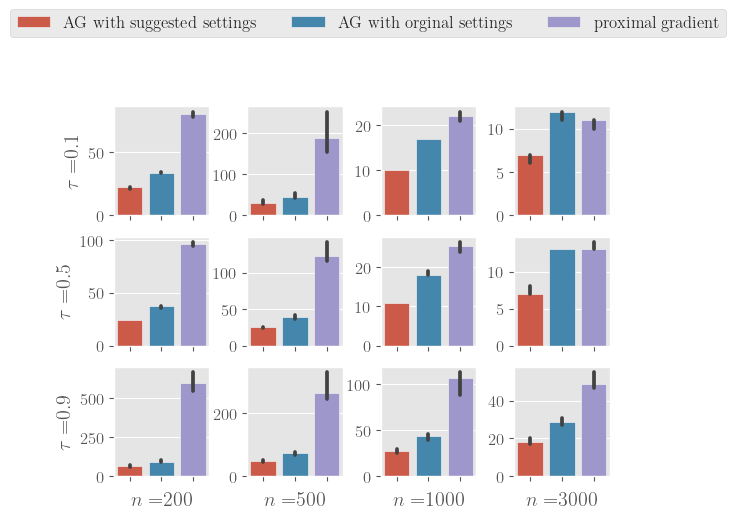

In [18]:
fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
N = np.array([200, 500, 1000, 3000])

for i, j in itertools.product(range(3), range(4)):
    df = pd.DataFrame(columns=[
        'AG with suggested settings', 'proximal gradient',
        'AG with orginal settings'
    ],
                      data=MCP_sim_results[i, j, ...])
    df_melted = pd.melt(df,
                        id_vars=[],
                        value_vars=[
                            'AG with suggested settings',
                            'AG with orginal settings', 'proximal gradient'
                        ],
                        var_name='method',
                        value_name='k')
    #     sns.boxplot(ax=axes[i, j], data=df_melted, x="method", y="k", hue="method", showfliers = False)#.set_title(r'$\tau=$'+str(tau[i])+'$, N=$'+str(N[j]))
    sns.barplot(ax=axes[i, j],
                data=df_melted,
                x="method",
                y="k",
                hue="method",
                estimator=np.median,
                ci=95,
                dodge=False)  #, palette = "Greys")
    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=r"$n=$" + str(N[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=[],
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=[],
                   xlabel=r"$n=$" + str(N[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=[], xlabel=None, ylabel=None)

    axes[i, j].get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=3,
           bbox_to_anchor=(-.05, 1.1))
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=.4,
                    hspace=None)

#plt.tight_layout()
plt.savefig('logistic-fig_k_MCP.eps',
            format='eps',
            dpi=600,
            bbox_inches='tight')
plt.show()

# logistic -- Signals
## SCAD
### AG

In [19]:
results_SCAD_signal_recovery = np.load(
    "./tasks/task2/results_SCAD_signal_recovery.npy")

results_SCAD_signal_recovery_mean = np.around(
    np.mean(results_SCAD_signal_recovery, 2), 3)
results_SCAD_signal_recovery_se = np.around(
    np.std(results_SCAD_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 0],
          results_SCAD_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 1],
          results_SCAD_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 2],
          results_SCAD_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 3],
          results_SCAD_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_SCAD_signal_recovery_se[..., 4]))

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_median[...,2])
# print("specificity: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_mad[...,2])
# print("specificity: ",results_SCAD_signal_recovery_mad[...,3])

logistic_SCAD_signal_latex = pasta(results_SCAD_signal_recovery_mean,
                                   results_SCAD_signal_recovery_se)

Sample mean:
2-norm:  [['0.768 (0.047)' '0.81 (0.041)' '0.896 (0.04)']
 ['0.556 (0.057)' '0.656 (0.054)' '0.839 (0.056)']
 ['0.377 (0.076)' '0.521 (0.073)' '0.779 (0.072)']
 ['0.311 (0.077)' '0.474 (0.073)' '0.757 (0.079)']]
infinity-norm:  [['2.393 (0.452)' '2.473 (0.402)' '2.732 (0.462)']
 ['2.02 (0.41)' '2.167 (0.384)' '2.679 (0.44)']
 ['1.638 (0.373)' '1.895 (0.347)' '2.592 (0.449)']
 ['1.467 (0.382)' '1.789 (0.358)' '2.582 (0.422)']]
PPV:  [['0.8 (0.079)' '0.779 (0.1)' '0.697 (0.126)']
 ['0.875 (0.054)' '0.859 (0.065)' '0.765 (0.096)']
 ['0.901 (0.052)' '0.881 (0.057)' '0.788 (0.098)']
 ['0.915 (0.048)' '0.899 (0.054)' '0.789 (0.097)']]
NPV:  [['0.982 (0.001)' '0.98 (0.001)' '0.978 (0.001)']
 ['0.985 (0.002)' '0.982 (0.001)' '0.979 (0.001)']
 ['0.987 (0.002)' '0.984 (0.001)' '0.979 (0.001)']
 ['0.988 (0.002)' '0.984 (0.001)' '0.979 (0.001)']]
active set cardi:  [['17.07 (3.91)' '13.4 (3.365)' '7.62 (2.134)']
 ['23.34 (4.203)' '16.59 (3.459)' '8.69 (2.082)']
 ['26.98 (4.58)' '19.46

### ncvreg

In [20]:
results_SCAD_signal_recovery = np.load(
    "./SCAD_MCP/logistic/R_results_SCAD_signal_recovery.npy")
results_SCAD_signal_recovery = np.reshape(results_SCAD_signal_recovery,
                                          (4, 3, 100, 5),
                                          "F")  # keep array dimension true

results_SCAD_signal_recovery_mean = np.around(
    np.mean(results_SCAD_signal_recovery, 2), 3)
results_SCAD_signal_recovery_se = np.around(
    np.std(results_SCAD_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 0],
          results_SCAD_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_SCAD_signal_recovery_mean[..., 1],
          results_SCAD_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 2],
          results_SCAD_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_SCAD_signal_recovery_mean[..., 3],
          results_SCAD_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_SCAD_signal_recovery_se[..., 4]))

# results_SCAD_signal_recovery_median = cp.median(results_SCAD_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_SCAD_signal_recovery_median[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_median[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_median[...,2])
# print("specificity: ",results_SCAD_signal_recovery_median[...,3])
# results_SCAD_signal_recovery_mad = mad(results_SCAD_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_SCAD_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_SCAD_signal_recovery_mad[...,1])
# print("sensitivity: ",results_SCAD_signal_recovery_mad[...,2])
# print("specificity: ",results_SCAD_signal_recovery_mad[...,3])

ncvreg_logistic_SCAD_signal_latex = pasta(results_SCAD_signal_recovery_mean,
                                          results_SCAD_signal_recovery_se)

Sample mean:
2-norm:  [['0.803 (0.033)' '0.84 (0.033)' '0.903 (0.037)']
 ['0.603 (0.053)' '0.682 (0.055)' '0.813 (0.053)']
 ['0.438 (0.054)' '0.537 (0.074)' '0.735 (0.074)']
 ['0.377 (0.064)' '0.481 (0.079)' '0.712 (0.078)']]
infinity-norm:  [['2.44 (0.44)' '2.507 (0.419)' '2.724 (0.505)']
 ['2.088 (0.435)' '2.19 (0.411)' '2.625 (0.488)']
 ['1.755 (0.403)' '1.901 (0.387)' '2.518 (0.448)']
 ['1.62 (0.401)' '1.79 (0.372)' '2.459 (0.4)']]
PPV:  [['0.221 (0.045)' '0.265 (0.079)' '0.309 (0.169)']
 ['0.244 (0.052)' '0.273 (0.072)' '0.273 (0.133)']
 ['0.27 (0.04)' '0.271 (0.079)' '0.267 (0.136)']
 ['0.29 (0.05)' '0.279 (0.072)' '0.26 (0.123)']]
NPV:  [['0.987 (0.002)' '0.985 (0.002)' '0.98 (0.001)']
 ['0.99 (0.002)' '0.987 (0.002)' '0.98 (0.001)']
 ['0.992 (0.001)' '0.988 (0.001)' '0.98 (0.001)']
 ['0.992 (0.001)' '0.988 (0.001)' '0.98 (0.001)']]
active set cardi:  [['120.14 (28.882)' '86.49 (24.421)' '39.41 (19.448)']
 ['134.85 (29.96)' '98.48 (28.434)' '42.47 (15.014)']
 ['130.33 (22.255)' 

### plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


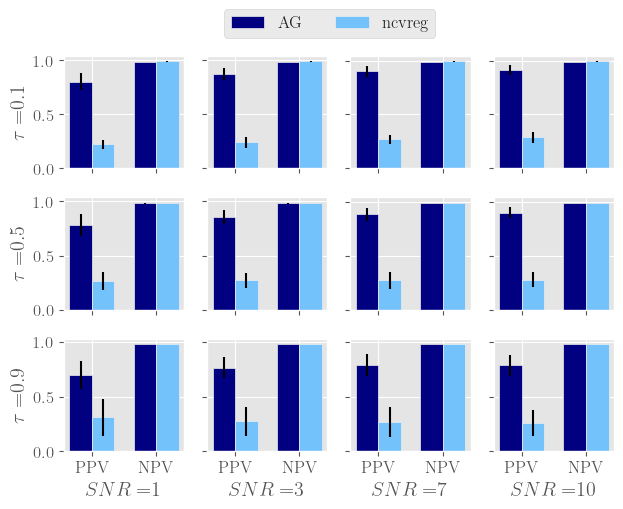

In [21]:
AG = np.load("./tasks/task2/results_SCAD_signal_recovery.npy")
AG_mean = np.mean(AG, 2)
AG_se = np.std(AG, 2)
ncvreg = np.load("./SCAD_MCP/logistic/R_results_SCAD_signal_recovery.npy")
ncvreg = np.reshape(ncvreg, (4, 3, 100, 5), "F")  # keep array dimension true
ncvreg_mean = np.mean(ncvreg, 2)
ncvreg_se = np.std(ncvreg, 2)

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
SNR = np.array([1, 3, 7, 10])

for i, j in itertools.product(range(3), range(4)):
    data = np.array([[AG_mean[j, i, 2], ncvreg_mean[j, i, 2]],
                     [AG_mean[j, i, 3], ncvreg_mean[j, i, 3]]])
    data_se = np.array([[AG_se[j, i, 2], ncvreg_se[j, i, 2]],
                        [AG_se[j, i, 3], ncvreg_se[j, i, 3]]])
    length = len(data)
    x_labels = ["PPV", "NPV"]
    width = 0.35  # width of bar
    x = np.arange(length)
    axes[i, j].bar(x,
                   data[:, 0],
                   width,
                   color='#000080',
                   label='AG',
                   yerr=data_se[:, 0])
    axes[i, j].bar(x + width,
                   data[:, 1],
                   width,
                   color='#73C2FB',
                   label='ncvreg',
                   yerr=data_se[:, 1])
    #     ax.set_ylabel('Proportion')
    #     ax.set_ylim(0,75)
    axes[i, j].set_xticks(x + width / 2)
    axes[i, j].set_xticklabels(x_labels)
    axes[i, j].set_xlabel('Predicted Values')
    #     ax.set_title('Title')
    #     axes[i,j].legend()

    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=r"$SNR=$" + str(SNR[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=x_labels,
                   xlabel=r"$SNR=$" + str(SNR[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels, xlabel=None, ylabel=None)

for ax in axes.flat:
    ax.label_outer()

# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout(pad=.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=4,
           bbox_to_anchor=(.35, 1.075))

plt.tight_layout()
plt.savefig('logistic-SCAD-pv.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

## MCP
### AG

In [22]:
results_MCP_signal_recovery = np.load(
    "./tasks/task2/results_MCP_signal_recovery.npy")

results_MCP_signal_recovery_mean = np.around(
    np.mean(results_MCP_signal_recovery, 2), 3)
results_MCP_signal_recovery_se = np.around(
    np.std(results_MCP_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 0],
          results_MCP_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 1],
          results_MCP_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 2],
          results_MCP_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 3],
          results_MCP_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_MCP_signal_recovery_mean[..., 4],
          results_MCP_signal_recovery_se[..., 4]))

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_median[...,2])
# print("specificity: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_mad[...,2])
# print("specificity: ",results_MCP_signal_recovery_mad[...,3])

logistic_MCP_signal_latex = pasta(results_MCP_signal_recovery_mean,
                                  results_MCP_signal_recovery_se)

Sample mean:
2-norm:  [['0.769 (0.044)' '0.808 (0.041)' '0.897 (0.043)']
 ['0.555 (0.058)' '0.654 (0.053)' '0.834 (0.054)']
 ['0.383 (0.08)' '0.521 (0.069)' '0.779 (0.07)']
 ['0.31 (0.079)' '0.469 (0.073)' '0.753 (0.076)']]
infinity-norm:  [['2.396 (0.453)' '2.467 (0.396)' '2.737 (0.458)']
 ['2.019 (0.414)' '2.168 (0.391)' '2.676 (0.44)']
 ['1.649 (0.394)' '1.889 (0.366)' '2.605 (0.457)']
 ['1.459 (0.359)' '1.791 (0.335)' '2.591 (0.426)']]
PPV:  [['0.879 (0.06)' '0.859 (0.058)' '0.779 (0.087)']
 ['0.906 (0.05)' '0.889 (0.05)' '0.805 (0.086)']
 ['0.919 (0.044)' '0.903 (0.05)' '0.809 (0.102)']
 ['0.918 (0.045)' '0.911 (0.038)' '0.804 (0.111)']]
NPV:  [['0.981 (0.001)' '0.98 (0.001)' '0.978 (0.001)']
 ['0.985 (0.002)' '0.982 (0.001)' '0.979 (0.001)']
 ['0.987 (0.002)' '0.984 (0.001)' '0.98 (0.001)']
 ['0.988 (0.002)' '0.984 (0.001)' '0.98 (0.001)']]
active set cardi:  [['13.86 (3.082)' '11.42 (2.776)' '6.72 (1.744)']
 ['21.86 (4.313)' '15.84 (3.036)' '8.84 (1.938)']
 ['25.75 (4.776)' '18.

### ncvreg

In [23]:
results_MCP_signal_recovery = np.load(
    "./SCAD_MCP/logistic/R_results_MCP_signal_recovery.npy")
results_MCP_signal_recovery = np.reshape(results_MCP_signal_recovery,
                                         (4, 3, 100, 5),
                                         "F")  # keep array dimension true

results_MCP_signal_recovery_mean = np.around(
    np.mean(results_MCP_signal_recovery, 2), 3)
results_MCP_signal_recovery_se = np.around(
    np.std(results_MCP_signal_recovery, 2), 3)
print("Sample mean:")
print(
    "2-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 0],
          results_MCP_signal_recovery_se[..., 0]))
print(
    "infinity-norm: ",
    pasta(results_MCP_signal_recovery_mean[..., 1],
          results_MCP_signal_recovery_se[..., 1]))
print(
    "PPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 2],
          results_MCP_signal_recovery_se[..., 2]))
print(
    "NPV: ",
    pasta(results_MCP_signal_recovery_mean[..., 3],
          results_MCP_signal_recovery_se[..., 3]))
print(
    "active set cardi: ",
    pasta(results_SCAD_signal_recovery_mean[..., 4],
          results_MCP_signal_recovery_se[..., 4]))

# results_MCP_signal_recovery_median = cp.median(results_MCP_signal_recovery, 2)
# print("Sample median:")
# print("2-norm: ",results_MCP_signal_recovery_median[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_median[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_median[...,2])
# print("specificity: ",results_MCP_signal_recovery_median[...,3])
# results_MCP_signal_recovery_mad = mad(results_MCP_signal_recovery.get(), 2)*1.4826
# print("Scaled MAD:")
# print("2-norm: ",results_MCP_signal_recovery_mad[...,0])
# print("infinity-norm: ",results_MCP_signal_recovery_mad[...,1])
# print("sensitivity: ",results_MCP_signal_recovery_mad[...,2])
# print("specificity: ",results_MCP_signal_recovery_mad[...,3])

ncvreg_logistic_MCP_signal_latex = pasta(results_MCP_signal_recovery_mean,
                                         results_MCP_signal_recovery_se)

Sample mean:
2-norm:  [['0.795 (0.036)' '0.829 (0.032)' '0.903 (0.038)']
 ['0.605 (0.049)' '0.674 (0.054)' '0.825 (0.057)']
 ['0.438 (0.057)' '0.533 (0.07)' '0.761 (0.071)']
 ['0.381 (0.061)' '0.48 (0.082)' '0.737 (0.077)']]
infinity-norm:  [['2.431 (0.447)' '2.489 (0.417)' '2.717 (0.467)']
 ['2.096 (0.427)' '2.187 (0.411)' '2.624 (0.494)']
 ['1.763 (0.398)' '1.901 (0.396)' '2.575 (0.477)']
 ['1.639 (0.397)' '1.79 (0.39)' '2.558 (0.462)']]
PPV:  [['0.372 (0.068)' '0.401 (0.106)' '0.375 (0.157)']
 ['0.43 (0.065)' '0.445 (0.106)' '0.395 (0.126)']
 ['0.463 (0.063)' '0.45 (0.104)' '0.417 (0.145)']
 ['0.502 (0.069)' '0.468 (0.095)' '0.412 (0.137)']]
NPV:  [['0.986 (0.002)' '0.983 (0.001)' '0.978 (0.001)']
 ['0.989 (0.002)' '0.985 (0.001)' '0.979 (0.001)']
 ['0.991 (0.002)' '0.986 (0.001)' '0.98 (0.001)']
 ['0.991 (0.001)' '0.987 (0.001)' '0.98 (0.001)']]
active set cardi:  [['120.14 (14.138)' '86.49 (12.546)' '39.41 (8.393)']
 ['134.85 (13.203)' '98.48 (14.5)' '42.47 (9.784)']
 ['130.33 (11

### plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


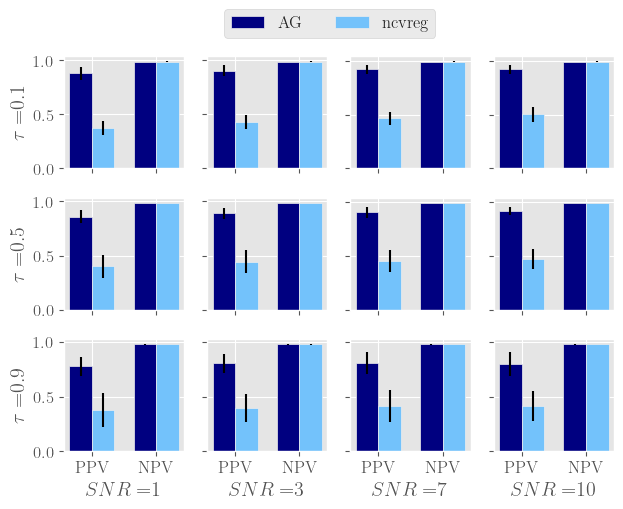

In [24]:
AG = np.load("./tasks/task2/results_MCP_signal_recovery.npy")
AG_mean = np.mean(AG, 2)
AG_se = np.std(AG, 2)
ncvreg = np.load("./SCAD_MCP/logistic/R_results_MCP_signal_recovery.npy")
ncvreg = np.reshape(ncvreg, (4, 3, 100, 5), "F")  # keep array dimension true
ncvreg_mean = np.mean(ncvreg, 2)
ncvreg_se = np.std(ncvreg, 2)

fig, axes = plt.subplots(3, 4)

tau = np.array([.1, .5, .9])
SNR = np.array([1, 3, 7, 10])

for i, j in itertools.product(range(3), range(4)):
    data = np.array([[AG_mean[j, i, 2], ncvreg_mean[j, i, 2]],
                     [AG_mean[j, i, 3], ncvreg_mean[j, i, 3]]])
    data_se = np.array([[AG_se[j, i, 2], ncvreg_se[j, i, 2]],
                        [AG_se[j, i, 3], ncvreg_se[j, i, 3]]])
    length = len(data)
    x_labels = ["PPV", "NPV"]
    width = 0.35  # width of bar
    x = np.arange(length)
    axes[i, j].bar(x,
                   data[:, 0],
                   width,
                   color='#000080',
                   label='AG',
                   yerr=data_se[:, 0])
    axes[i, j].bar(x + width,
                   data[:, 1],
                   width,
                   color='#73C2FB',
                   label='ncvreg',
                   yerr=data_se[:, 1])
    #     ax.set_ylabel('Proportion')
    #     ax.set_ylim(0,75)
    axes[i, j].set_xticks(x + width / 2)
    axes[i, j].set_xticklabels(x_labels)
    axes[i, j].set_xlabel('Predicted Values')
    #     ax.set_title('Title')
    #     axes[i,j].legend()

    if i == 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=r"$SNR=$" + str(SNR[j]),
                       ylabel=None)  # yticklabels=[] to remove y scales
    if j == 0 and i != 2:
        axes[i, j].set(xticklabels=x_labels,
                       xlabel=None,
                       ylabel=r"$\tau=$" + str(tau[i]))
    axes[2, 0].set(xticklabels=x_labels,
                   xlabel=r"$SNR=$" + str(SNR[0]),
                   ylabel=r"$\tau=$" + str(tau[2]))
    if i != 2 and j != 0:
        axes[i, j].set(xticklabels=x_labels, xlabel=None, ylabel=None)

for ax in axes.flat:
    ax.label_outer()

# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout(pad=.2)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles,
           labels,
           loc='upper left',
           ncol=4,
           bbox_to_anchor=(.35, 1.075))

plt.tight_layout()
plt.savefig('logistic-MCP-pv.eps', format='eps', dpi=600, bbox_inches='tight')
plt.show()

# LaTeX output

In [25]:
def merge_row_by_row(A, B):
    nrow, ncol = A.shape
    _nrow, _ncol = B.shape
    assert nrow == _nrow and ncol == _ncol
    C = np.empty((nrow * 2, ncol), dtype=A.dtype)
    C[np.arange(nrow) * 2, :] = A
    C[np.arange(nrow) * 2 + 1, :] = B
    return C


def dollar(x):
    return "$" + x + "$"


def output_latex(A, B):
    output = pd.DataFrame(merge_row_by_row(A, B))
    return output.to_latex(formatters=[dollar, dollar, dollar],
                           header=[r"$\tau$=0.1", r"$0.5$", r"$0.9$"])

In [26]:
print("signal recovery for LM SCAD")
for j in [0, 2, 3, 4]:
    print(
        output_latex(LM_SCAD_signal_latex[..., j],
                     ncvreg_LM_SCAD_signal_latex[..., j]))

signal recovery for LM SCAD
\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.128 (0.021)\$ &  \$0.521 (0.114)\$ &  \$2.839 (0.497)\$ \\
1 &   \$0.131 (0.02)\$ &  \$0.485 (0.102)\$ &  \$2.929 (0.525)\$ \\
2 &   \$0.05 (0.009)\$ &  \$0.156 (0.035)\$ &  \$2.075 (0.339)\$ \\
3 &  \$0.052 (0.009)\$ &  \$0.156 (0.028)\$ &  \$2.087 (0.357)\$ \\
4 &  \$0.022 (0.004)\$ &  \$0.085 (0.014)\$ &  \$1.278 (0.262)\$ \\
5 &  \$0.021 (0.004)\$ &  \$0.083 (0.015)\$ &    \$1.3 (0.262)\$ \\
6 &  \$0.016 (0.003)\$ &  \$0.065 (0.011)\$ &  \$1.163 (0.207)\$ \\
7 &  \$0.015 (0.003)\$ &  \$0.063 (0.013)\$ &   \$1.167 (0.22)\$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.747 (0.134)\$ &  \$0.622 (0.188)\$ &   \$0.488 (0.25)\$ \\
1 &  \$0.255 (0.061)\$ &  \$0.287 (0.132)\$ &   \$0.286 (0.19)\$ \\
2 &  \$0.681 (0.162

In [27]:
print("signal recovery for LM MCP")
for j in [0, 2, 3, 4]:
    print(
        output_latex(LM_MCP_signal_latex[..., j],
                     ncvreg_LM_MCP_signal_latex[..., j]))

signal recovery for LM MCP
\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.133 (0.022)\$ &  \$0.563 (0.124)\$ &   \$2.839 (0.39)\$ \\
1 &  \$0.126 (0.019)\$ &  \$0.494 (0.112)\$ &   \$2.86 (0.427)\$ \\
2 &   \$0.049 (0.01)\$ &  \$0.169 (0.034)\$ &  \$1.997 (0.329)\$ \\
3 &  \$0.048 (0.009)\$ &  \$0.161 (0.032)\$ &    \$1.92 (0.34)\$ \\
4 &  \$0.021 (0.004)\$ &  \$0.088 (0.016)\$ &  \$1.503 (0.329)\$ \\
5 &   \$0.02 (0.004)\$ &  \$0.086 (0.017)\$ &  \$1.416 (0.302)\$ \\
6 &  \$0.014 (0.003)\$ &  \$0.059 (0.011)\$ &  \$1.084 (0.272)\$ \\
7 &  \$0.014 (0.003)\$ &  \$0.059 (0.013)\$ &  \$1.134 (0.248)\$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &   \$0.85 (0.081)\$ &  \$0.744 (0.161)\$ &  \$0.616 (0.208)\$ \\
1 &  \$0.435 (0.085)\$ &  \$0.407 (0.135)\$ &  \$0.387 (0.154)\$ \\
2 &  \$0.842 (0.119)

In [28]:
print("signal recovery for logistic SCAD")
for j in [0, 2, 3, 4]:
    print(
        output_latex(logistic_SCAD_signal_latex[..., j],
                     ncvreg_logistic_SCAD_signal_latex[..., j]))

signal recovery for logistic SCAD
\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.768 (0.047)\$ &   \$0.81 (0.041)\$ &   \$0.896 (0.04)\$ \\
1 &  \$0.803 (0.033)\$ &   \$0.84 (0.033)\$ &  \$0.903 (0.037)\$ \\
2 &  \$0.556 (0.057)\$ &  \$0.656 (0.054)\$ &  \$0.839 (0.056)\$ \\
3 &  \$0.603 (0.053)\$ &  \$0.682 (0.055)\$ &  \$0.813 (0.053)\$ \\
4 &  \$0.377 (0.076)\$ &  \$0.521 (0.073)\$ &  \$0.779 (0.072)\$ \\
5 &  \$0.438 (0.054)\$ &  \$0.537 (0.074)\$ &  \$0.735 (0.074)\$ \\
6 &  \$0.311 (0.077)\$ &  \$0.474 (0.073)\$ &  \$0.757 (0.079)\$ \\
7 &  \$0.377 (0.064)\$ &  \$0.481 (0.079)\$ &  \$0.712 (0.078)\$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &    \$0.8 (0.079)\$ &    \$0.779 (0.1)\$ &  \$0.697 (0.126)\$ \\
1 &  \$0.221 (0.045)\$ &  \$0.265 (0.079)\$ &  \$0.309 (0.169)\$ \\
2 &  \$0.875 

In [29]:
print("signal recovery for logistic MCP")
for j in [0, 2, 3, 4]:
    print(
        output_latex(logistic_MCP_signal_latex[..., j],
                     ncvreg_logistic_MCP_signal_latex[..., j]))

signal recovery for logistic MCP
\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &  \$0.769 (0.044)\$ &  \$0.808 (0.041)\$ &  \$0.897 (0.043)\$ \\
1 &  \$0.795 (0.036)\$ &  \$0.829 (0.032)\$ &  \$0.903 (0.038)\$ \\
2 &  \$0.555 (0.058)\$ &  \$0.654 (0.053)\$ &  \$0.834 (0.054)\$ \\
3 &  \$0.605 (0.049)\$ &  \$0.674 (0.054)\$ &  \$0.825 (0.057)\$ \\
4 &   \$0.383 (0.08)\$ &  \$0.521 (0.069)\$ &   \$0.779 (0.07)\$ \\
5 &  \$0.438 (0.057)\$ &   \$0.533 (0.07)\$ &  \$0.761 (0.071)\$ \\
6 &   \$0.31 (0.079)\$ &  \$0.469 (0.073)\$ &  \$0.753 (0.076)\$ \\
7 &  \$0.381 (0.061)\$ &   \$0.48 (0.082)\$ &  \$0.737 (0.077)\$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &       \$\textbackslash tau\$=0.1 &            \$0.5\$ &            \$0.9\$ \\
\midrule
0 &   \$0.879 (0.06)\$ &  \$0.859 (0.058)\$ &  \$0.779 (0.087)\$ \\
1 &  \$0.372 (0.068)\$ &  \$0.401 (0.106)\$ &  \$0.375 (0.157)\$ \\
2 &   \$0.906 